In [20]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from numpy import expand_dims, zeros, ones, vstack
from numpy.random import randn, randint
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout


In [21]:
import tensorflow
from tensorflow.keras.datasets.mnist import load_data
(trainX,trainY), (testX,testY) = load_data()

In [22]:
print('Train', trainX.shape, trainY.shape)

Train (60000, 28, 28) (60000,)


In [23]:
print('Test', testX.shape, testY.shape)

Test (10000, 28, 28) (10000,)


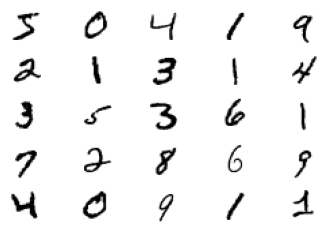

In [24]:
import matplotlib.pyplot as pyplot
for i in range(25):
  # define subplot
  pyplot.subplot(5, 5, 1 + i)
  # turn off axis
  pyplot.axis('off')
  # plot raw pixel data
  pyplot.imshow(trainX[i], cmap='gray_r')
pyplot.show()

In [25]:
def discriminator(in_shape = (28, 28, 1)):
    disc = Sequential()
    disc.add(Conv2D(64, (3, 3), strides = (2, 2), padding = 'same', input_shape = in_shape))
    disc.add(LeakyReLU(alpha = 0.2))
    disc.add(Dropout(0.4))
    disc.add(Conv2D(64, (3, 3), strides = (2, 2), padding = 'same'))
    disc.add(LeakyReLU(alpha = 0.2))
    disc.add(Dropout(0.4))
    disc.add(Flatten())
    disc.add(Dense(1, activation = 'sigmoid'))
    o = Adam(lr = 0.0002, beta_1 = 0.5)
    disc.compile(loss = 'binary_crossentropy', optimizer = o, metrics = ['accuracy'])
    return disc

In [26]:
def generator(latent_dim):
    gen = Sequential()
    nodes = 128 * 7 * 7
    gen.add(Dense(nodes, input_dim = latent_dim))
    gen.add(LeakyReLU(alpha = 0.2))
    gen.add(Reshape((7, 7, 128)))
    # to unsample to 14x14 images
    gen.add(Conv2DTranspose(128, (4, 4), strides = (2, 2), padding = 'same'))
    gen.add(LeakyReLU(alpha = 0.2))
    # unsampling t 28x28 images
    gen.add(Conv2DTranspose(128, (4, 4), strides = (2, 2), padding = 'same'))
    gen.add(LeakyReLU(alpha = 0.2))
    gen.add(Conv2D(1, (7, 7), activation = 'sigmoid', padding = 'same'))
    return gen

In [27]:
def DCGAN(gm, dm):
    dm.trainable = False
    model = Sequential()
    model.add(gm) #adding generator model
    model.add(dm) #adding descriminator model
    o = Adam(lr = 0.0002, beta_1 = 0.5)
    model.compile(loss = 'binary_crossentropy', optimizer = o)
    return model

In [28]:
def load_real():
    (X_train, _), (_, _) = load_data()
    X = expand_dims(X_train, axis = -1) # adding dimension to make image 3 dimensional
    X = X.astype('float32') # converting pixel values from unsigned integers to floating numbers
    X = X / 255.0 # normalizing pixel values
    return X

In [29]:
# To select training batches for each epoch
def gen_real(df, n_samples):
    n = randint(0, df.shape[0], n_samples)
    X = df[n]
    y = ones((n_samples, 1))
    return X, y

In [30]:
# To generate latent points to be converted to handwritten digits
def gen_latent(latent_dim, n_samples):
    xin = randn(latent_dim * n_samples)
    xin = xin.reshape(n_samples, latent_dim)
    return xin

In [32]:
# To generate fake samples
def gen_fake(gm, latent_dim, n_samples):
    xin = gen_latent(latent_dim, n_samples)
    X = gm.predict(xin)
    y = zeros((n_samples, 1))
    return X, y

In [33]:

# To plot the generated images
def genplot(examples , epoch, n = 5, save = False):
    for i in range(n * n):
        plt.subplot(n, n, i + 1)
        plt.axis('off')
        plt.imshow(examples[i, :, :, 0], cmap = 'gray_r')
    if(save == True):
        plt.savefig('generatedplot_e%03d.png'%(epoch+1))
    plt.close()

In [34]:

# To evaluate the model and save
def evaluate_gan(epoch, gm, dm, df, latent_dim, n_samples = 100):
    Xr, yr = gen_real(df, n_samples)
    _, acc_real = dm.evaluate(Xr, yr, verbose = 0)
    Xf, yf = gen_fake(gm, latent_dim, n_samples)
    _, acc_fake = dm.evaluate(Xf, yf, verbose = 0)
    print(">Accuracy real: %.0f%%, fake: %.0f%% " % (acc_real * 100, acc_fake * 100))
    genplot(Xf, epoch, save = True)
    gm.save("DCGAN.h5")

In [35]:
def train(gm, dm, gan, df, latent_dim, n_epochs = 100, n_batch = 300):
    batch = int(df.shape[0]/n_batch)
    half_batch = int(n_batch/2)
    for i in range(n_epochs):
        for j in range(batch):
            X_real, y_real = gen_real(df, half_batch)
            X_fake, y_fake = gen_fake(gm, latent_dim, half_batch)
            X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
            d_loss, _ = dm.train_on_batch(X, y)
            X_gan = gen_latent(latent_dim, n_batch)
            y_gan = ones((n_batch, 1))
            g_loss = gan.train_on_batch(X_gan, y_gan)
            print('>%d, %d/%d, d = %.3f, g = %.3f'%(i+1, j+1, batch, d_loss, g_loss))
        if(i+1) % 10 == 0:
            evaluate_gan(i, gm, dm, df, latent_dim)

In [36]:
latent_dim = 100
d_model = discriminator()
g_model = generator(latent_dim)
gan_model = DCGAN(g_model, d_model)
dataset = load_real()
train(g_model, d_model, gan_model, dataset, latent_dim)

>1, 1/200, d = 0.692, g = 0.734
>1, 2/200, d = 0.686, g = 0.755
>1, 3/200, d = 0.673, g = 0.775
>1, 4/200, d = 0.667, g = 0.794
>1, 5/200, d = 0.659, g = 0.815
>1, 6/200, d = 0.650, g = 0.824
>1, 7/200, d = 0.649, g = 0.843
>1, 8/200, d = 0.640, g = 0.847
>1, 9/200, d = 0.644, g = 0.845
>1, 10/200, d = 0.644, g = 0.840
>1, 11/200, d = 0.646, g = 0.824
>1, 12/200, d = 0.649, g = 0.798
>1, 13/200, d = 0.653, g = 0.775
>1, 14/200, d = 0.653, g = 0.752
>1, 15/200, d = 0.658, g = 0.737
>1, 16/200, d = 0.655, g = 0.726
>1, 17/200, d = 0.650, g = 0.718
>1, 18/200, d = 0.644, g = 0.712
>1, 19/200, d = 0.640, g = 0.707
>1, 20/200, d = 0.632, g = 0.704
>1, 21/200, d = 0.626, g = 0.702
>1, 22/200, d = 0.615, g = 0.700
>1, 23/200, d = 0.603, g = 0.699
>1, 24/200, d = 0.597, g = 0.698
>1, 25/200, d = 0.585, g = 0.699
>1, 26/200, d = 0.578, g = 0.699
>1, 27/200, d = 0.573, g = 0.700
>1, 28/200, d = 0.563, g = 0.700
>1, 29/200, d = 0.558, g = 0.701
>1, 30/200, d = 0.542, g = 0.701
>1, 31/200, d = 0.5

KeyboardInterrupt: 

In [38]:
print("THANK YOU !")

THANK YOU !
